# Direct Neural Biasing - Python Demo

## STEP 1 - Python Imports

In [179]:
from pathlib import Path
from time import time
import math
import json
import csv
import re
import gc

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne
import direct_neural_biasing as dnb

## STEP 2 - Define Data Array

#### 2.1 - Read EDF File

In [180]:
file = './data/JS.edf' # place an EDF file in the /data dir

raw = mne.io.read_raw_edf(file)
sample_freq = raw.info["sfreq"]
data_full = raw.get_data().flatten()

Extracting EDF parameters from C:\data\UCL\DirectNeuralBiasing\src\pythonlib\data\JS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\dan\AppData\Local\Temp/ipykernel_4320/3436388220.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file)


In [181]:
# Temporary hack that imports 'data' from CSV 
# data = pd.read_csv('signal.csv').values.flatten()

#### 2.2 - Optional - Truncate data array for debug

In [182]:
data = data_full[0:10000000]
# data = data_full

In [183]:
len(data)

10000000

#### 2.3 - Optional write data to csv

In [184]:
filename = 'data.csv'
np.savetxt(filename, data, delimiter=',')

print(f'Array saved to {filename}')

Array saved to data.csv


## STEP 3 - Setup SignalProcesser

#### 3.1 - Create Signal Processor

In [185]:
verbose = True # verbose=True gives more verbose output in results object for debugging
signal_processor = dnb.PySignalProcessor(verbose, sample_freq)

#### 3.2 - Create Filters

In [186]:
slow_wave_filter_id = 'bandpass_filter_slow_wave'
f_low = 0.5 # cutoff_low
f_high = 4.0 # cutoff_high

signal_processor.add_filter(slow_wave_filter_id, f_low, f_high, sample_freq)

In [187]:
ied_filter_id = 'bandpass_filter_ied'
f_low = 80.0 # cutoff_low
f_high = 120.0 # cutoff_high

signal_processor.add_filter(ied_filter_id, f_low, f_high, sample_freq)

#### 3.3 - Create Slow Wave Detector

In [188]:
slow_wave_detector_id = 'slow_wave_detector'
z_score_threshold = 1.0 # candidate wave amplitude threhsold
sinusoidness_threshold = 0.5 # cosine wave correlation, between 0 and 1.

signal_processor.add_slow_wave_detector(
    slow_wave_detector_id,
    slow_wave_filter_id, # which filtered_signal should the detector read from
    z_score_threshold,
    sinusoidness_threshold,
)

#### 3.4 - Create IED Detector

In [189]:
ied_detector_id = 'ied_detector'
z_score_threshold = 5.0 # threhsold for candidate detection event
buffer_size = 10 # length of buffer - to manage noise resistance
sensitivy = 0.5 # Between 0 and 1. Ratio of values in buffer OVER threshold required to trigger an 'IED Detected' event.

signal_processor.add_threshold_detector(
    ied_detector_id,
    ied_filter_id, # which filtered_signal should the detector read from
    z_score_threshold,
    buffer_size,
    sensitivy
)

#### 3.5 - Create Pulse Trigger

In [190]:
trigger_id = 'pulse_trigger'
inhibition_cooldown_ms = 2000 # ms cooldown after IED detection
pulse_cooldown_ms = 2000 # ms cooldown after pulse event

signal_processor.add_pulse_trigger(
    trigger_id,
    slow_wave_detector_id, # which detector triggers a pulse - SlowWave in this case
    ied_detector_id, # which detector triggers an inhibition cooldown - IED in this case
    inhibition_cooldown_ms,
    pulse_cooldown_ms
)

## STEP 4 - Analyse Signal

#### 4.1 - Run

In [191]:
from collections import deque
import time

def data_generator(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        print(f'processing chunk {i // chunk_size + 1} of size: {chunk_size}')
        yield data[i:i + chunk_size]

def process_chunk(signal_processor, data_chunk):
    return signal_processor.run_chunk(data_chunk)

def run_in_series(processor, data_generator, chunk_size, context_size):
    buffer_size = (context_size * 2) + 1
    event_buffer = deque(maxlen=buffer_size)  # Ring buffer with context samples
    results = []  # List to hold the final output arrays
    
    # Reset index to zero each time you re-analyse the data
    processor.reset_index()
    
    chunk_count = 0
    detected_events = 0
    
    for chunk in data_generator:
        if len(chunk) > 0:
            chunk_count += 1
            start_time = time.time()  # Start timer before analysis
            chunk_output = process_chunk(processor, chunk)
            duration = time.time() - start_time

            print(f"Processed chunk {chunk_count} in {duration:.4f}s")

            for sample_result in chunk_output:
                event_buffer.append(sample_result)

                # If the buffer is full, analyze the middle sample and remove the oldest sample
                if len(event_buffer) >= buffer_size:
                    # Check if the sample in the middle of the buffer is an event
                    middle_sample = event_buffer[context_size]
                    
                    # If the middle sample is an event, store the context
                    if middle_sample.get("triggers:pulse_trigger:triggered", 0.0) == 1.0:
                        detected_events += 1
                        print(f"Detected event {detected_events} at buffer index {context_size}")

                        # Append the entire buffer to results
                        results.append(list(event_buffer))

                    # Pop the oldest sample
                    event_buffer.popleft()

    return results

# Example usage
chunk_size = int(1e5)  # Chunk size for processing
context_size = 2000  # Number of samples to include as context around events
data_gen = data_generator(data, chunk_size)
results = run_in_series(signal_processor, data_gen, chunk_size, context_size)

# The results object now contains the final output - a list of lists
# Each list contains <context_size> samples either side of an event
# i.e. if context_size is 2e4 (2000), each list will be 4001 samples long, and the event will be at sample index 2000

processing chunk 1 of size: 100000
Processed chunk 1 in 0.9336s
processing chunk 2 of size: 100000
Processed chunk 2 in 0.9194s
processing chunk 3 of size: 100000
Processed chunk 3 in 0.8559s
processing chunk 4 of size: 100000
Processed chunk 4 in 0.9227s
processing chunk 5 of size: 100000
Processed chunk 5 in 0.8684s
processing chunk 6 of size: 100000
Processed chunk 6 in 0.9891s
processing chunk 7 of size: 100000
Processed chunk 7 in 0.9727s
Detected event 1 at buffer index 2000
processing chunk 8 of size: 100000
Processed chunk 8 in 1.0322s
processing chunk 9 of size: 100000
Processed chunk 9 in 0.8455s
processing chunk 10 of size: 100000
Processed chunk 10 in 0.9319s
processing chunk 11 of size: 100000
Processed chunk 11 in 0.8788s
processing chunk 12 of size: 100000
Processed chunk 12 in 0.9125s
processing chunk 13 of size: 100000
Processed chunk 13 in 0.8629s
processing chunk 14 of size: 100000
Processed chunk 14 in 0.8926s
processing chunk 15 of size: 100000
Processed chunk 15 i

#### 4.2 - Example Sample Output

#### 4.3 - Save Output as CSV

In [192]:
len(results)

23

In [193]:
# Define the output file name
output_file = 'output.csv'

# Create flattened version of results
flat_results = [
    x
    for xs in results
    for x in xs
]

# Collect all unique keys from all dictionaries in the list
unique_keys = set()
for row in flat_results:
    unique_keys.update(row.keys())

# Convert the set of unique keys to a list and sort it to ensure consistent column order
headers = sorted(unique_keys)

# Write the data to a CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()  # Write the header row
    for row in flat_results:
        # Ensure each row has all headers, filling missing values with None or an empty string
        writer.writerow({key: row.get(key, None) for key in headers})

print(f'Data successfully written to {output_file}')

Data successfully written to output.csv


## STEP 5 - Check Filtered Signal Against Scipy

#### 5.1 - Prepare Signal Arrays

In [194]:
start_index = int(results[0][0].get('global:index')) # start index if first segment
end_index = int(results[0][-1].get('global:index')) # end index of first segment

raw_signal = data[start_index:end_index + 1]
dnb_raw_signal = [sample['global:raw_sample'] for sample in results[0]]
dnb_slow_wave_filtered_signal = [sample[f'filters:{slow_wave_filter_id}:filtered_sample'] for sample in results[0]]
dnb_ied_filtered_signal = [sample[f'filters:{ied_filter_id}:filtered_sample'] for sample in results[0]]

#### 5.2 - Create Scipy Filtered Signals

##### 5.2.3 - SlowWave Filter Test

In [195]:
# SciPy filtering parameters
order = 2
lowcut = 0.5  # Low cut frequency in Hz
highcut = 4.0  # High cut frequency in Hz

# Design a Butterworth bandpass filter using SciPy
b, a = signal.butter(order, [lowcut, highcut], 'bp', fs= sample_freq)

# Apply the filter to the raw signal using SciPy
scipy_filtered_signal_slowwave_test = signal.lfilter(b, a, raw_signal)

##### 5.2.1 - IED Filter Test

In [196]:
# SciPy filtering parameters
order = 2
lowcut = 80.0  # Low cut frequency in Hz
highcut = 120.0  # High cut frequency in Hz

# Design a Butterworth bandpass filter using SciPy
b, a = signal.butter(order, [lowcut, highcut], 'bp', fs= sample_freq)

# Apply the filter to the raw signal using SciPy
scipy_filtered_signal_ied_test = signal.lfilter(b, a, raw_signal)

#### 5.3 - Truncate Signals for Easier Debug

In [197]:
start_idx = 0
end_idx = 4001

raw_signal_truncated = raw_signal[start_idx:end_idx]
dnb_raw_signal_truncated = dnb_raw_signal[start_idx:end_idx]
dnb_slow_wave_filtered_signal_truncated = dnb_slow_wave_filtered_signal[start_idx:end_idx]
dnb_ied_filtered_signal_truncated = dnb_ied_filtered_signal[start_idx:end_idx]
scipy_filtered_signal_slowwave_test_truncated = scipy_filtered_signal_slowwave_test[start_idx:end_idx]
scipy_filtered_signal_ied_test_truncated = scipy_filtered_signal_ied_test[start_idx:end_idx]

#### 5.4 - Plot Graphs

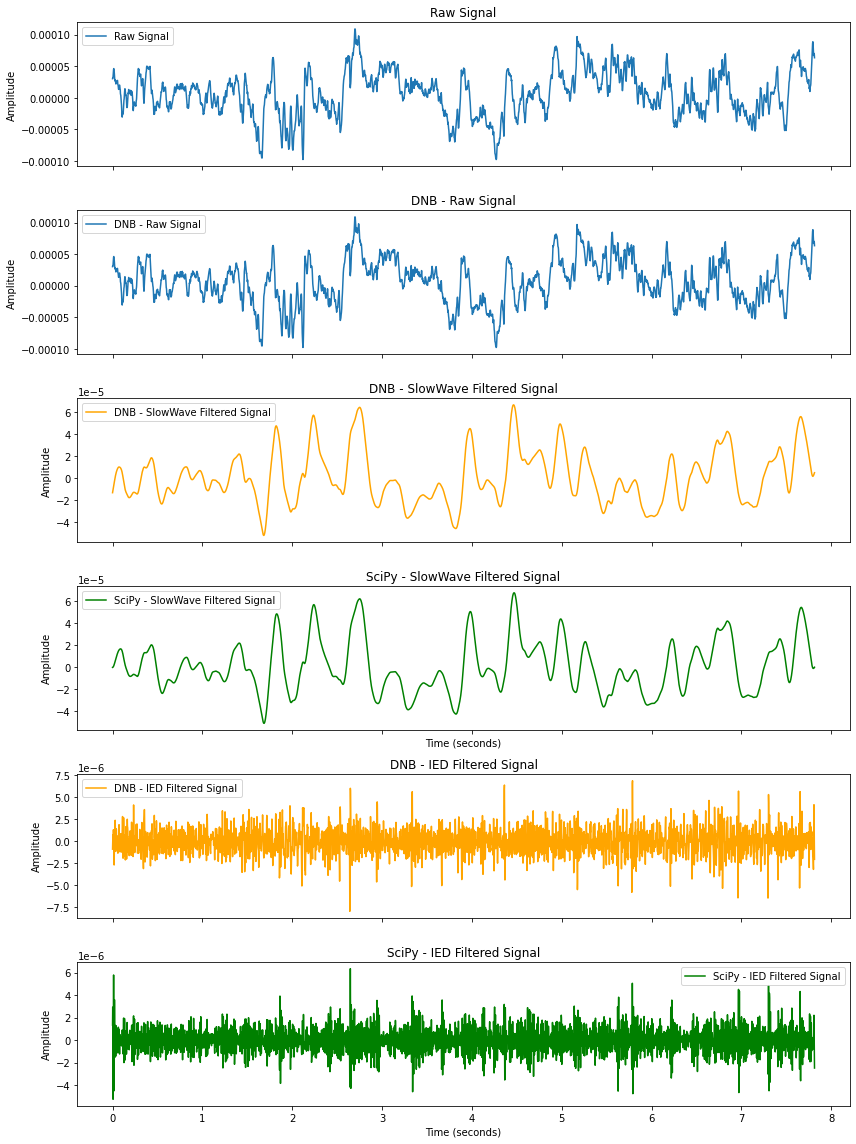

In [198]:
# Convert sample indices to time in seconds
time = np.arange(len(raw_signal_truncated)) / sample_freq

# Plot the four graphs
fig, axs = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

# Plot the raw signal
axs[0].plot(time, raw_signal_truncated, label='Raw Signal')
axs[0].set_title('Raw Signal')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot the dnb_raw signal
axs[1].plot(time, dnb_raw_signal_truncated, label='DNB - Raw Signal')
axs[1].set_title('DNB - Raw Signal')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

# Plot the dnb_filtered signal
axs[2].plot(time, dnb_slow_wave_filtered_signal_truncated, label='DNB - SlowWave Filtered Signal', color='orange')
axs[2].set_title('DNB - SlowWave Filtered Signal')
axs[2].set_ylabel('Amplitude')
axs[2].legend()

# Plot the sciPy_filtered signal
axs[3].plot(time, scipy_filtered_signal_slowwave_test_truncated, label='SciPy - SlowWave Filtered Signal', color='green')
axs[3].set_title('SciPy - SlowWave Filtered Signal')
axs[3].set_xlabel('Time (seconds)')
axs[3].set_ylabel('Amplitude')
axs[3].legend()

# Plot the dnb_filtered signal
axs[4].plot(time, dnb_ied_filtered_signal_truncated, label='DNB - IED Filtered Signal', color='orange')
axs[4].set_title('DNB - IED Filtered Signal')
axs[4].set_ylabel('Amplitude')
axs[4].legend()

# Plot the sciPy_filtered signal
axs[5].plot(time, scipy_filtered_signal_ied_test_truncated, label='SciPy - IED Filtered Signal', color='green')
axs[5].set_title('SciPy - IED Filtered Signal')
axs[5].set_xlabel('Time (seconds)')
axs[5].set_ylabel('Amplitude')
axs[5].legend()

# Show the plots
plt.tight_layout()
plt.show()

## STEP 6 - Find Detected Events & Display JSON

#### 6.1 - Focus on Events Only

In [199]:
events = [result[context_size] for result in results]

#### 6.2 - Display JSON with nice structure

In [200]:
# Initialize an empty dictionary to hold structured data
structured_data = {}

# Iterate through each event in the list
for idx, event in enumerate(events):
    event_key = f'event_{idx}'
    structured_data[event_key] = {'detectors': {}, 'global': {}, 'filters': {}, 'triggers': {}}
    
    for key, value in event.items():
        category, sub_key = key.split(':', 1)
        
        if category == 'detectors':
            detector_type, detector_key = sub_key.split(':', 1)
            if detector_type not in structured_data[event_key]['detectors']:
                structured_data[event_key]['detectors'][detector_type] = {}
            structured_data[event_key]['detectors'][detector_type][detector_key] = value
        
        elif category == 'filters':
            filter_type, filter_key = sub_key.split(':', 1)
            if filter_type not in structured_data[event_key]['filters']:
                structured_data[event_key]['filters'][filter_type] = {}
            structured_data[event_key]['filters'][filter_type][filter_key] = value
        
        elif category == 'triggers':
            trigger_type, trigger_key = sub_key.split(':', 1)
            if trigger_type not in structured_data[event_key]['triggers']:
                structured_data[event_key]['triggers'][trigger_type] = {}
            structured_data[event_key]['triggers'][trigger_type][trigger_key] = value
        
        elif category == 'global':
            structured_data[event_key]['global'][sub_key] = value

# Convert back to float NaN where necessary
def convert_nan(value):
    return value if not isinstance(value, float) or not math.isnan(value) else float('nan')

for event_key, categories in structured_data.items():
    for category_key, sub_categories in categories.items():
        if isinstance(sub_categories, dict):
            for sub_category_key, values in sub_categories.items():
                if isinstance(values, dict):
                    for value_key, value in values.items():
                        structured_data[event_key][category_key][sub_category_key][value_key] = convert_nan(value)
                else:
                    structured_data[event_key][category_key][sub_category_key] = convert_nan(values)

# Print the final structured data with NaN values converted - if you want
# print(json.dumps(structured_data, indent=4))

## STEP 7 - Visualise Detected Events

#### 7.1 - Print all samples superimposed

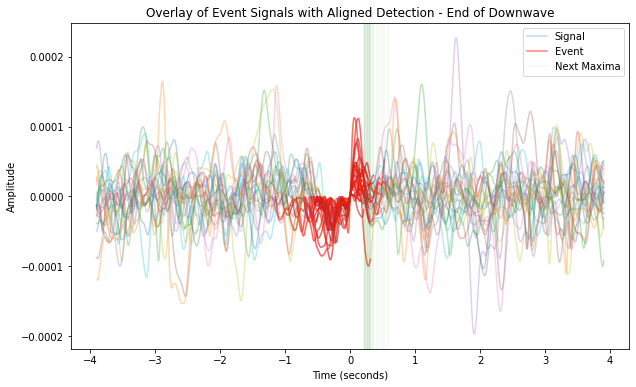

In [201]:
import matplotlib.pyplot as plt
import numpy as np

def plot_events_with_context(events, sample_freq, context_size):
    plt.figure(figsize=(10, 6))

    for segment in events:
        # Extract the signal segment to plot
        segment_data = [sample.get('filters:bandpass_filter_slow_wave:filtered_sample', 0.0) for sample in segment]
        normalized_time = np.arange(-context_size, context_size + 1) / sample_freq

        # Plot the signal segment
        plt.plot(normalized_time, segment_data, label='Signal', alpha=0.3)

        # Extract the indices
        first_sample_index = segment[0].get('global:index')
        event_sample = segment[context_size]
        downwave_start_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event_sample.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        # Normalize indices
        normalized_downwave_start_idx = int(downwave_start_idx - first_sample_index)
        normalized_downwave_end_idx = int(downwave_end_idx - first_sample_index)
        normalized_predicted_next_maxima_idx = int(predicted_next_maxima_idx - first_sample_index)

        # Ensure the indices are within the segment bounds
        if normalized_downwave_start_idx < 0 or normalized_downwave_end_idx >= len(segment_data):
            continue

        # Highlight the event signal
        event_segment_data = segment_data[normalized_downwave_start_idx:normalized_predicted_next_maxima_idx + 1]
        normalized_event_times = normalized_time[normalized_downwave_start_idx:normalized_predicted_next_maxima_idx + 1]

        # Plot the event signal
        plt.plot(normalized_event_times, event_segment_data, color='red', alpha=0.5)

        # Plot the predicted next maxima as a green vertical line at the predicted maxima time
        plt.axvline(x=normalized_time[normalized_predicted_next_maxima_idx], color='green', linestyle='-', alpha=0.05)

    # Add labels and legend
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Overlay of Event Signals with Aligned Detection - End of Downwave')
    plt.ticklabel_format(useOffset=False)
    plt.legend(['Signal', 'Event', 'Next Maxima'])
    plt.show()

# Example usage
sample_freq = 512.0  # Sample frequency
plot_events_with_context(results, sample_freq, context_size)


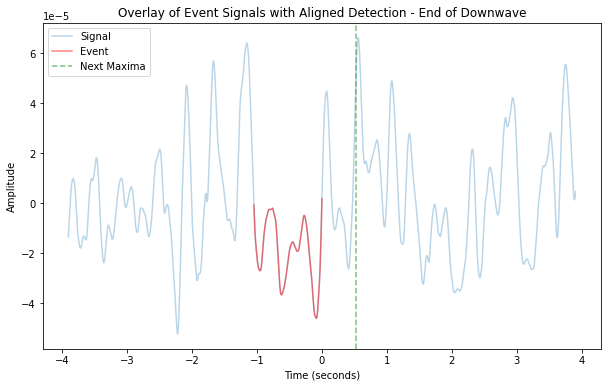

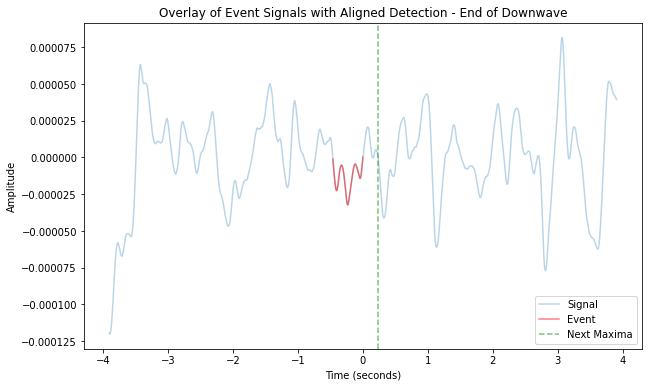

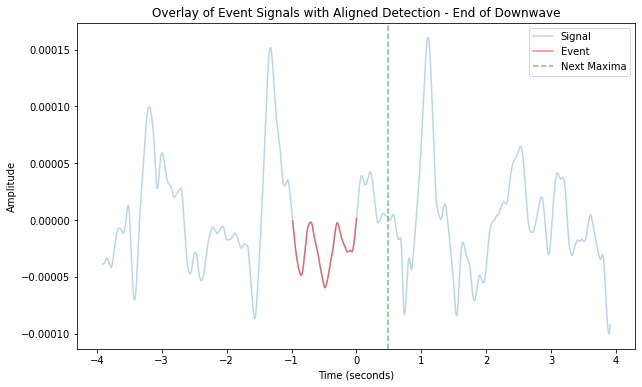

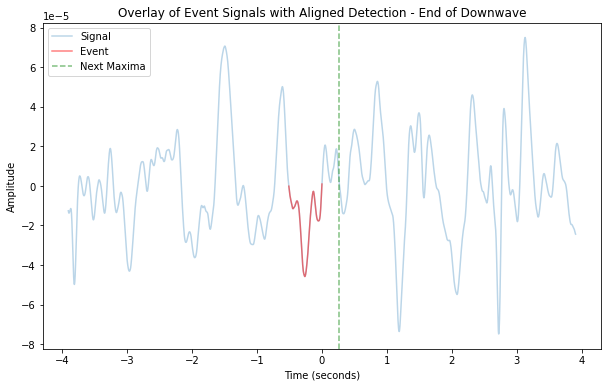

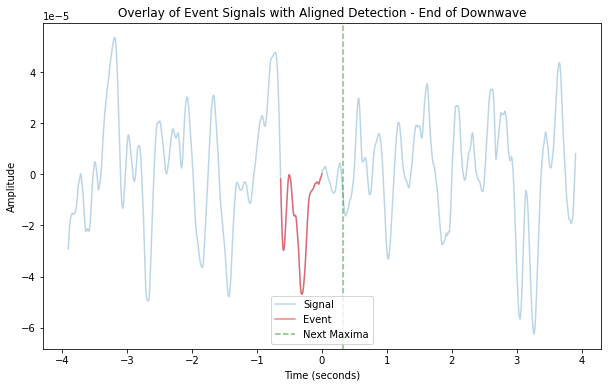

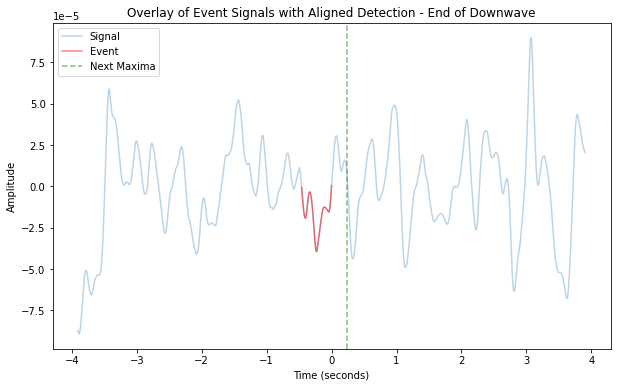

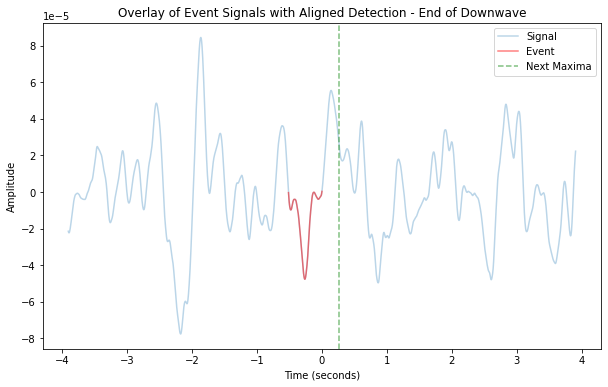

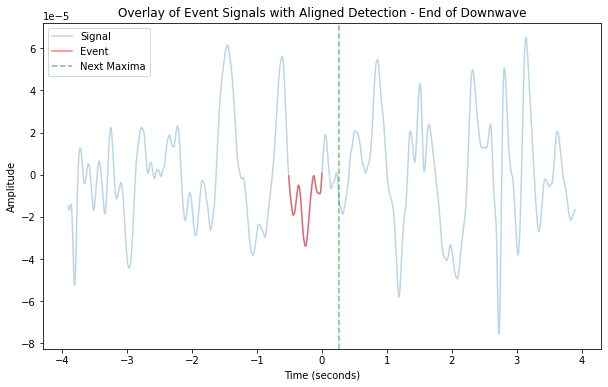

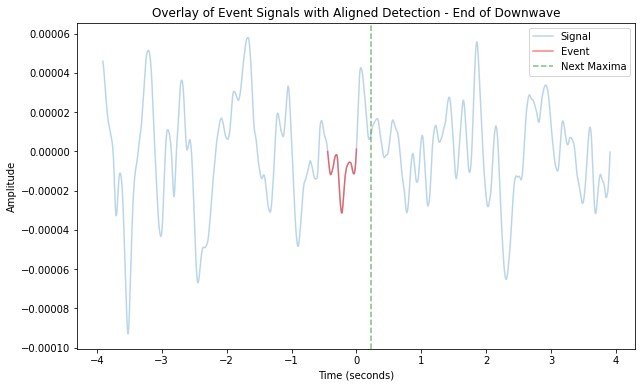

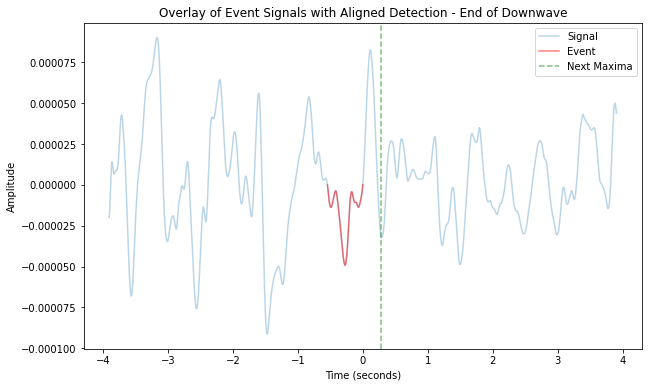

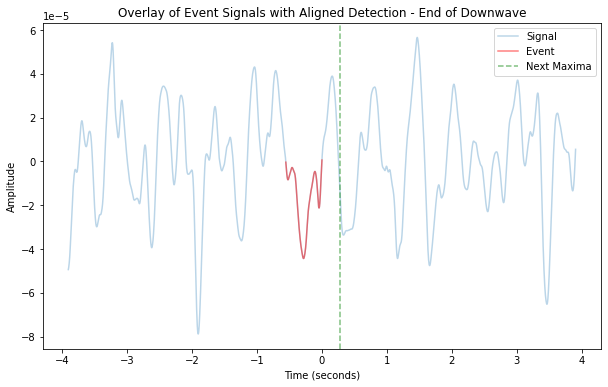

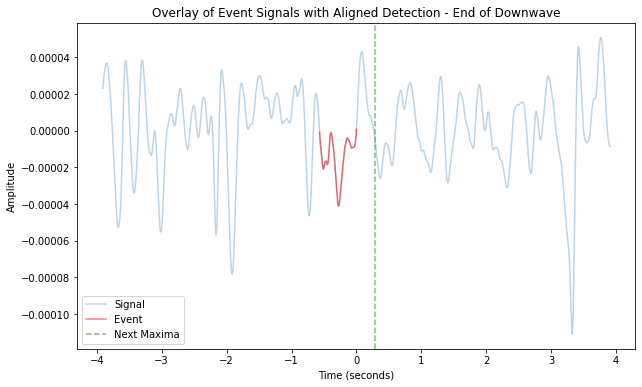

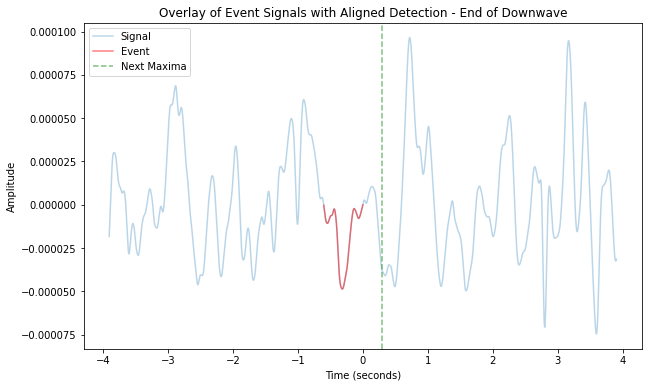

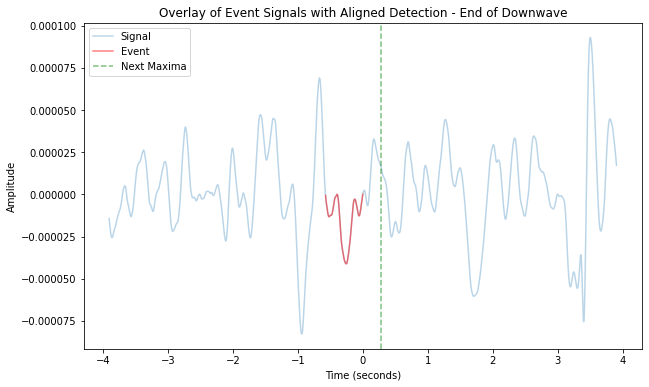

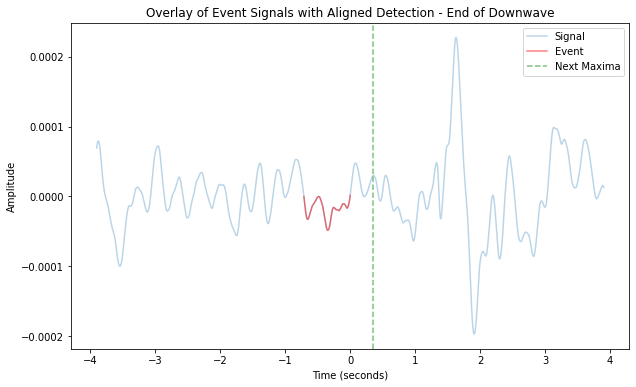

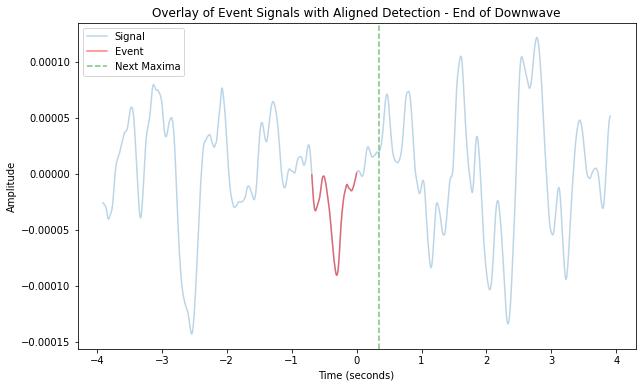

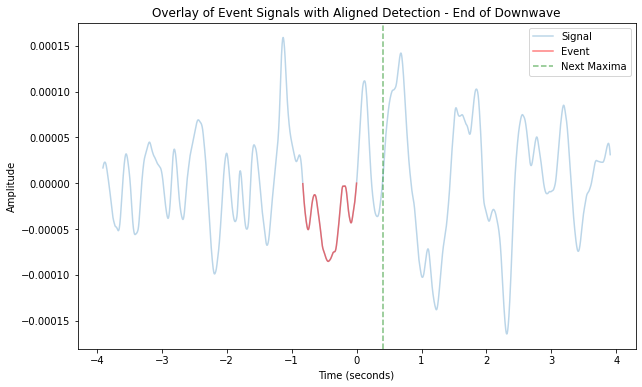

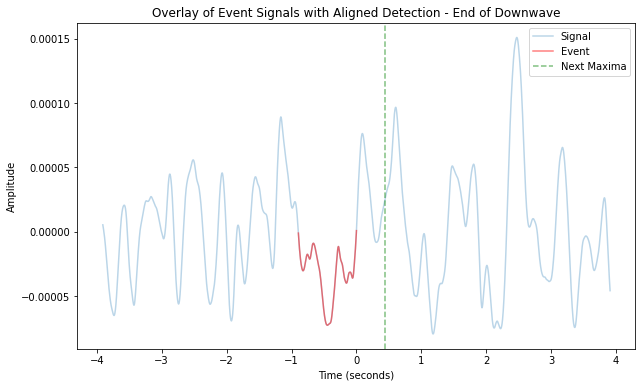

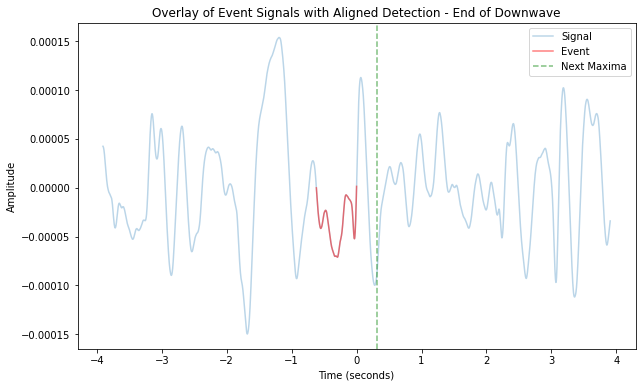

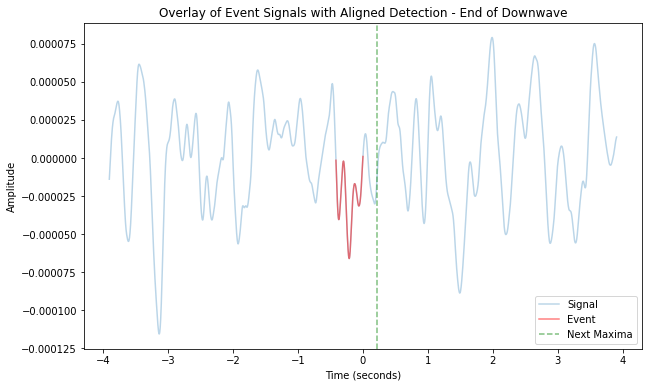

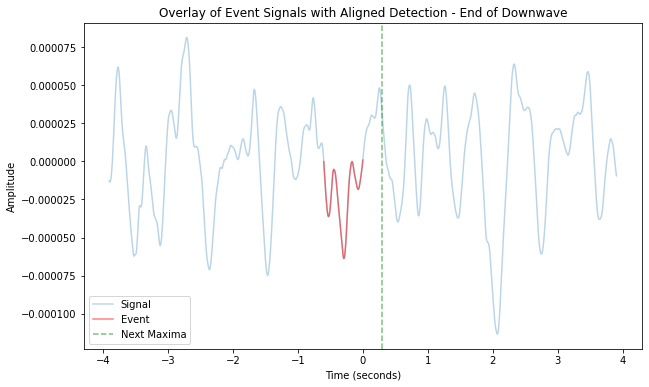

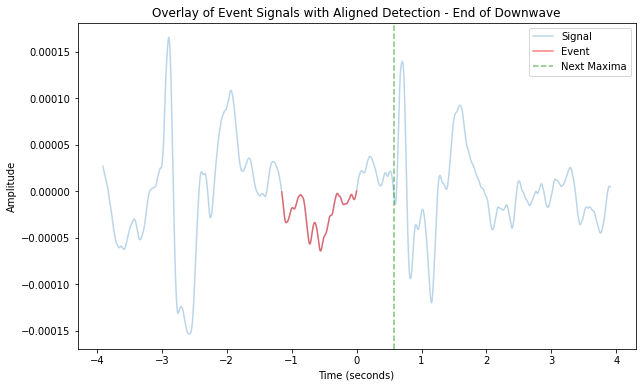

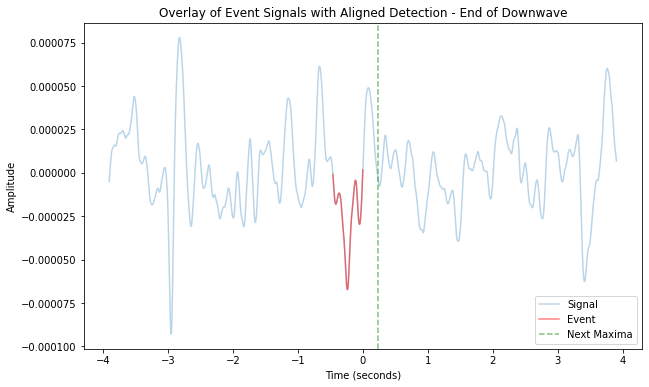

In [202]:
import matplotlib.pyplot as plt
import numpy as np

def plot_events_with_context(events, sample_freq, context_size):
    for segment in results:
        plt.figure(figsize=(10, 6))
        
        # Extract the signal segment to plot
        segment_data = [sample.get('filters:bandpass_filter_slow_wave:filtered_sample', 0.0) for sample in segment]
        normalized_time = np.arange(-context_size, context_size + 1) / sample_freq

        # Plot the signal segment
        plt.plot(normalized_time, segment_data, label='Signal', alpha=0.3)

        # Extract the indices
        first_sample_index = segment[0].get('global:index')
        event_sample = segment[context_size]
        downwave_start_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event_sample.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        # Normalize indices
        normalized_downwave_start_idx = int(downwave_start_idx - first_sample_index)
        normalized_downwave_end_idx = int(downwave_end_idx - first_sample_index)
        normalized_predicted_next_maxima_idx = int(predicted_next_maxima_idx - first_sample_index)

        # Ensure the indices are within the segment bounds
        if normalized_downwave_start_idx < 0 or normalized_downwave_end_idx >= len(segment_data):
            continue

        # Highlight the event signal
        event_segment_data = segment_data[normalized_downwave_start_idx:normalized_downwave_end_idx + 1]
        normalized_event_times = normalized_time[normalized_downwave_start_idx:normalized_downwave_end_idx + 1]

        # Plot the event signal
        plt.plot(normalized_event_times, event_segment_data, color='red', alpha=0.5)

        # Plot the predicted next maxima as a green vertical line at the predicted maxima time
        plt.axvline(x=normalized_time[normalized_predicted_next_maxima_idx], color='green', linestyle='--', alpha=0.5)

        # Add labels and legend
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('Overlay of Event Signals with Aligned Detection - End of Downwave')
        plt.ticklabel_format(useOffset=False)
        plt.legend(['Signal', 'Event', 'Next Maxima'])
        plt.show()

# Example usage
sample_freq = 512.0  # Sample frequency
plot_events_with_context(results, sample_freq, context_size)


## DEBUG - VISUALISE IED EVENTS

#### NOTE - This is mainly for Dan H and most of it may not run / run as you expect

#### NOTE - There is no cooldown on IED detection, so each IED results in multiple 'detections'

In [ ]:
ied_detections = [item for item in out if item[f'detectors:{ied_detector_id}:detected'] == 1.0]

In [ ]:
signal_padding_factor = 2

# Function to extract indices and plot each event
def plot_ied_events(data, detections, signal_padding_factor, sample_freq):
    for detection in detections:
        # Extract the index of the IED event
        ied_idx = detection.get('global:index')

        # Debugging the index
        print(f"ied_idx: {ied_idx}")

        # Determine the range for plotting
        extra_length = signal_padding_factor * sample_freq
        start_idx = int(max(0, ied_idx - extra_length))
        end_idx = int(min(len(data), ied_idx + extra_length))

        # Extract the signal segment to plot
        segment = data[start_idx:end_idx]

        # Convert indices to time in seconds
        time = np.arange(start_idx, end_idx) / sample_freq

        # Debugging lengths
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        print(f"segment length: {len(segment)}, time length: {len(time)}")

        # Plot the signal segment
        plt.figure(figsize=(10, 4))
        plt.plot(time, segment, label='Signal')

        # Highlight the IED event
        ied_time = ied_idx / sample_freq
        plt.axvline(x=ied_time, color='red', linestyle='--', label='IED Event')

        # Add labels and legend
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('IED Event Signal')
        plt.ticklabel_format(useOffset=False)
        plt.legend()
        plt.show()

# Example usage
# Assuming `data` is your signal array and `events` is your list of event dictionaries
plot_ied_events(dnb_ied_filtered_signal, ied_detections, signal_padding_factor, sample_freq)

#### print all events on the same timeline

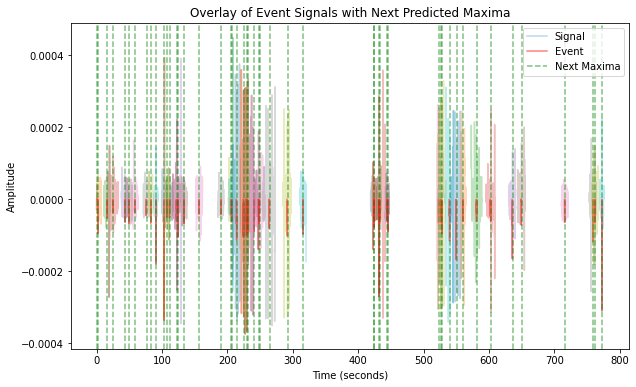

In [66]:
import numpy as np
import matplotlib.pyplot as plt

signal_padding_factor = 10

# Function to extract indices and plot all events on top of each other
def plot_trigger_events(data, events, signal_padding_factor, sample_freq):
    plt.figure(figsize=(10, 6))
    
    for event in events:
        # Extract the indices from the event keys
        downwave_start_idx = int(event.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        if downwave_start_idx == -1 or downwave_end_idx == -1 or predicted_next_maxima_idx == -1:
            continue  # Skip if any of the indices are invalid

        # Determine the range for plotting
        event_length = downwave_end_idx - downwave_start_idx
        extra_length = event_length * signal_padding_factor
        start_idx = max(0, downwave_start_idx - extra_length)
        end_idx = min(len(data), downwave_end_idx + extra_length)

        # Extract the signal segment to plot
        segment = data[start_idx:end_idx]

        # Convert indices to time in seconds
        time = np.arange(start_idx, end_idx) / sample_freq

        # Plot the signal segment
        plt.plot(time, segment, label='Signal', alpha=0.3)

        # Highlight the event signal
        event_times = np.arange(downwave_start_idx, downwave_end_idx) / sample_freq
        event_segment = data[downwave_start_idx:downwave_end_idx]

        # Ensure the lengths of event_times and event_segment match
        if len(event_times) != len(event_segment):
            continue

        plt.plot(event_times, event_segment, color='red', alpha=0.5)

        # Plot the predicted next maxima as a green vertical line
        next_maxima_time = predicted_next_maxima_idx / sample_freq
        plt.axvline(x=next_maxima_time, color='green', linestyle='--', alpha=0.5)

    # Add labels and legend
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Overlay of Event Signals with Next Predicted Maxima')
    plt.ticklabel_format(useOffset=False)
    plt.legend(['Signal', 'Event', 'Next Maxima'])
    plt.show()

# Example usage
# Assuming `data` is your signal array and `events` is your list of event dictionaries
plot_trigger_events(dnb_slow_wave_filtered_signal, events[0:50], signal_padding_factor, sample_freq)


## read in pre-processed file

In [24]:
import csv
import ast
import json
import matplotlib.pyplot as plt
import numpy as np

def read_output_csv(file_path):
    all_events = []
    current_events = []
    previous_index = -1

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            try:
                # Each line is a complete JSON dictionary
                event = json.loads(line.strip())
                current_index = int(event.get('global:index', -1))

                # Check for discontinuity
                if previous_index != -1 and current_index != previous_index + 1:
                    if current_events:
                        all_events.append(current_events)
                        current_events = []

                current_events.append(event)
                previous_index = current_index

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                continue

        # Add the last segment if any
        if current_events:
            all_events.append(current_events)

    return all_events

# Example usage
events = read_output_csv('data/output.csv')

In [25]:
len(events)

146

In [27]:
import math
import json

# Initialize an empty dictionary to hold structured data
structured_data = {}

for segment in events:
    event_sample = None
    event_index = None
    ied_detected = False
    global_idx = None

    # First run through the segment and find the sample where the event happened, store its global_index
    for idx, sample in enumerate(segment):
        if sample.get('triggers:main_trigger:triggered', 0.0) == 1.0:
            event_sample = sample
            event_index = idx
            global_idx = sample.get('global:index', -1)
            break  # Stop after finding the first event

    if event_sample is None:
        continue  # No event found in this segment

    structured_data[global_idx] = {
        'detectors': {},
        'filters': {},
        'triggers': {},
        'global': {}
    }

    for key, value in event_sample.items():
        category, sub_key = key.split(':', 1)

        if category == 'detectors':
            detector_type, detector_key = sub_key.split(':', 1)
            if detector_type not in structured_data[global_idx]['detectors']:
                structured_data[global_idx]['detectors'][detector_type] = {}
            structured_data[global_idx]['detectors'][detector_type][detector_key] = value

        elif category == 'filters':
            filter_type, filter_key = sub_key.split(':', 1)
            if filter_type not in structured_data[global_idx]['filters']:
                structured_data[global_idx]['filters'][filter_type] = {}
            structured_data[global_idx]['filters'][filter_type][filter_key] = value

        elif category == 'triggers':
            trigger_type, trigger_key = sub_key.split(':', 1)
            if trigger_type not in structured_data[global_idx]['triggers']:
                structured_data[global_idx]['triggers'][trigger_type] = {}
            structured_data[global_idx]['triggers'][trigger_type][trigger_key] = value

        elif category == 'global':
            structured_data[global_idx]['global'][sub_key] = value

In [28]:
sinusoidness_values = []

for event_key, event_data in structured_data.items():
    # print(f"Type of event_data: {type(event_data)}")  # Debugging print statement
    detectors = event_data.get('detectors', {})
    slow_wave_detector = detectors.get('slow_wave_detector', {})
    sinusoidness = slow_wave_detector.get('sinusoidness', None)
    if sinusoidness is not None:
        sinusoidness_values.append(sinusoidness)

if sinusoidness_values:
    highest_value = max(sinusoidness_values)
    lowest_value = min(sinusoidness_values)
    average_value = np.mean(sinusoidness_values)
    
    print(f"Highest sinusoidness: {highest_value}")
    print(f"Lowest sinusoidness: {lowest_value}")
    print(f"Average sinusoidness: {average_value}")
else:
    print("No sinusoidness values found in the event data.")

Highest sinusoidness: 0.6676442100494624
Lowest sinusoidness: 0.5002234776886789
Average sinusoidness: 0.5448639173412256


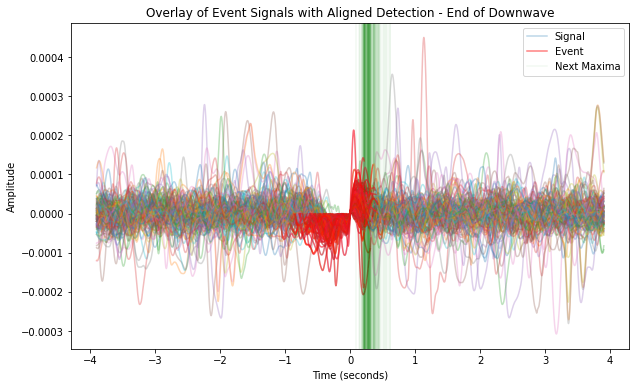

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_events_with_context(events, sample_freq, context_size):
    plt.figure(figsize=(10, 6))

    for segment in events:
        # Extract the signal segment to plot
        segment_data = [sample.get('filters:slow_wave_filter:filtered_sample', 0.0) for sample in segment]
        normalized_time = np.arange(-context_size, context_size + 1) / sample_freq

        # Plot the signal segment
        plt.plot(normalized_time, segment_data, label='Signal', alpha=0.3)

        # Extract the indices
        first_sample_index = segment[0].get('global:index')
        event_sample = segment[context_size]
        downwave_start_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event_sample.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        # Normalize indices
        normalized_downwave_start_idx = int(downwave_start_idx - first_sample_index)
        normalized_downwave_end_idx = int(downwave_end_idx - first_sample_index)
        normalized_predicted_next_maxima_idx = int(predicted_next_maxima_idx - first_sample_index)

        # Ensure the indices are within the segment bounds
        if normalized_downwave_start_idx < 0 or normalized_downwave_end_idx >= len(segment_data):
            continue

        # Highlight the event signal
        event_segment_data = segment_data[normalized_downwave_start_idx:normalized_predicted_next_maxima_idx + 1]
        normalized_event_times = normalized_time[normalized_downwave_start_idx:normalized_predicted_next_maxima_idx + 1]

        # Plot the event signal
        plt.plot(normalized_event_times, event_segment_data, color='red', alpha=0.5)

        # Plot the predicted next maxima as a green vertical line at the predicted maxima time
        plt.axvline(x=normalized_time[normalized_predicted_next_maxima_idx], color='green', linestyle='-', alpha=0.05)

    # Add labels and legend
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Overlay of Event Signals with Aligned Detection - End of Downwave')
    plt.ticklabel_format(useOffset=False)
    plt.legend(['Signal', 'Event', 'Next Maxima'])
    plt.show()

# Example usage
sample_freq = 512.0  # Sample frequency
context_size = 2000  # Context size around the event
plot_events_with_context(events, sample_freq, context_size)


In [139]:
import matplotlib.pyplot as plt
import numpy as np

def plot_events_with_context(events, sample_freq, context_size):
    for segment in events:
        plt.figure(figsize=(10, 6))
        
        # Extract the signal segment to plot
        segment_data = [sample.get('filters:slow_wave_filter:filtered_sample', 0.0) for sample in segment]
        normalized_time = np.arange(-context_size, context_size + 1) / sample_freq

        # Plot the signal segment
        plt.plot(normalized_time, segment_data, label='Signal', alpha=0.3)

        # Extract the indices
        first_sample_index = segment[0].get('global:index')
        event_sample = segment[context_size]
        downwave_start_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event_sample.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event_sample.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        # Normalize indices
        normalized_downwave_start_idx = int(downwave_start_idx - first_sample_index)
        normalized_downwave_end_idx = int(downwave_end_idx - first_sample_index)
        normalized_predicted_next_maxima_idx = int(predicted_next_maxima_idx - first_sample_index)

        # Ensure the indices are within the segment bounds
        if normalized_downwave_start_idx < 0 or normalized_downwave_end_idx >= len(segment_data):
            continue

        # Highlight the event signal
        event_segment_data = segment_data[normalized_downwave_start_idx:normalized_downwave_end_idx + 1]
        normalized_event_times = normalized_time[normalized_downwave_start_idx:normalized_downwave_end_idx + 1]

        # Plot the event signal
        plt.plot(normalized_event_times, event_segment_data, color='red', alpha=0.5)

        # Plot the predicted next maxima as a green vertical line at the predicted maxima time
        plt.axvline(x=normalized_time[normalized_predicted_next_maxima_idx], color='green', linestyle='--', alpha=0.5)

        # Add labels and legend
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('Overlay of Event Signals with Aligned Detection - End of Downwave')
        plt.ticklabel_format(useOffset=False)
        plt.legend(['Signal', 'Event', 'Next Maxima'])
        plt.show()

# Example usage
sample_freq = 512.0  # Sample frequency
context_size = 2000  # Context size around the event
plot_events_with_context(events[100:], sample_freq, context_size)
